In [6]:
from backtesting.test import GOOG, SMA

data = GOOG.copy()
data

,Open,High,Low,Close,Volume
2004-08-19,100.00,104.06,95.96,100.34,22351900
2004-08-20,101.01,109.08,100.50,108.31,11428600
2004-08-23,110.75,113.48,109.05,109.40,9137200
2004-08-24,111.24,111.60,103.57,104.87,7631300
2004-08-25,104.96,108.00,103.88,106.00,4598900
...,...,...,...,...,...
2013-02-25,802.30,808.41,790.49,790.77,2303900
2013-02-26,795.00,795.95,784.40,790.13,2202500
2013-02-27,794.80,804.75,791.11,799.78,2026100
2013-02-28,801.10,806.99,801.03,801.20,2265800


In [7]:
def BBANDS(data, n_lookback, n_std):
    """Bollinger bands indicator"""
    hlc3 = (data.High + data.Low + data.Close) / 3
    mean, std = hlc3.rolling(n_lookback).mean(), hlc3.rolling(n_lookback).std()
    upper = mean + n_std*std
    lower = mean - n_std*std
    return upper, lower


close = data.Close.values
sma10 = SMA(data.Close, 10)
sma20 = SMA(data.Close, 20)
sma50 = SMA(data.Close, 50)
sma100 = SMA(data.Close, 100)
upper, lower = BBANDS(data, 20, 2)

# Design matrix / independent features:

# Price-derived features
data['X_SMA10'] = (close - sma10) / close
data['X_SMA20'] = (close - sma20) / close
data['X_SMA50'] = (close - sma50) / close
data['X_SMA100'] = (close - sma100) / close

data['X_DELTA_SMA10'] = (sma10 - sma20) / close
data['X_DELTA_SMA20'] = (sma20 - sma50) / close
data['X_DELTA_SMA50'] = (sma50 - sma100) / close

# Indicator features
data['X_MOM'] = data.Close.pct_change(periods=2)
data['X_BB_upper'] = (upper - close) / close
data['X_BB_lower'] = (lower - close) / close
data['X_BB_width'] = (upper - lower) / close
data['X_Sentiment'] = ~data.index.to_series().between('2017-09-27', '2017-12-14')

# Some datetime features for good measure
data['X_day'] = data.index.dayofweek
data['X_hour'] = data.index.hour

data = data.dropna().astype(float)


In [8]:
import numpy as np


def get_X(data):
    """Return model design matrix X"""
    return data.filter(like='X').values


def get_y(data):
    """Return dependent variable y"""
    y = data.Close.pct_change(48).shift(-48)  # Returns after roughly two days
    y[y.between(-.004, .004)] = 0             # Devalue returns smaller than 0.4%
    y[y > 0] = 1
    y[y < 0] = -1
    return y


def get_clean_Xy(df):
    """Return (X, y) cleaned of NaN values"""
    X = get_X(df)
    y = get_y(df).values
    isnan = np.isnan(y)
    X = X[~isnan]
    y = y[~isnan]
    return X, y

Classification accuracy:  0.5524475524475524


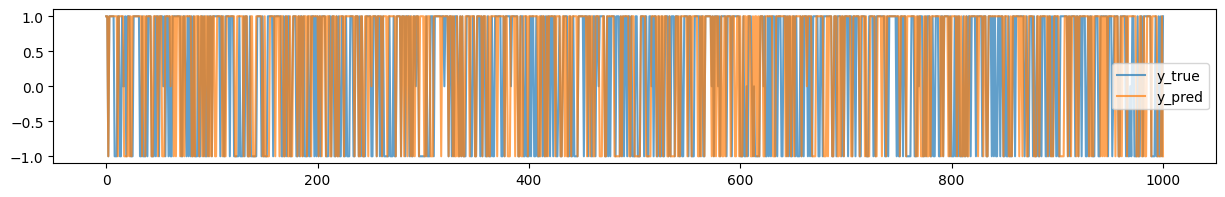

In [12]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X, y = get_clean_Xy(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=0)

clf = KNeighborsClassifier(7)  # Model the output based on 7 "nearest" examples
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

_ = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred}).plot(figsize=(15, 2), alpha=.7)
print('Classification accuracy: ', np.mean(y_test == y_pred))

In [13]:
%%time

from backtesting import Backtest, Strategy

N_TRAIN = 400


class MLTrainOnceStrategy(Strategy):
    price_delta = .004  # 0.4%

    def init(self):        
        # Init our model, a kNN classifier
        self.clf = KNeighborsClassifier(7)

        # Train the classifier in advance on the first N_TRAIN examples
        df = self.data.df.iloc[:N_TRAIN]
        X, y = get_clean_Xy(df)
        self.clf.fit(X, y)

        # Plot y for inspection
        self.I(get_y, self.data.df, name='y_true')

        # Prepare empty, all-NaN forecast indicator
        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')

    def next(self):
        # Skip the training, in-sample data
        if len(self.data) < N_TRAIN:
            return

        # Proceed only with out-of-sample data. Prepare some variables
        high, low, close = self.data.High, self.data.Low, self.data.Close
        current_time = self.data.index[-1]

        # Forecast the next movement
        X = get_X(self.data.df.iloc[-1:])
        forecast = self.clf.predict(X)[0]

        # Update the plotted "forecast" indicator
        self.forecasts[-1] = forecast

        # If our forecast is upwards and we don't already hold a long position
        # place a long order for 20% of available account equity. Vice versa for short.
        # Also set target take-profit and stop-loss prices to be one price_delta
        # away from the current closing price.
        upper, lower = close[-1] * (1 + np.r_[1, -1]*self.price_delta)

        if forecast == 1 and not self.position.is_long:
            self.buy(size=.2, tp=upper, sl=lower)
        elif forecast == -1 and not self.position.is_short:
            self.sell(size=.2, tp=lower, sl=upper)

        # Additionally, set aggressive stop-loss on trades that have been open 
        # for more than two days
        for trade in self.trades:
            if current_time - trade.entry_time > pd.Timedelta('2 days'):
                if trade.is_long:
                    trade.sl = max(trade.sl, low)
                else:
                    trade.sl = min(trade.sl, high)


bt = Backtest(data, MLTrainOnceStrategy, commission=.0002, margin=.05)
bt.run()

CPU times: total: 1.95 s
Wall time: 5.52 s


Start                     2005-01-10 00:00:00
End                       2013-03-01 00:00:00
Duration                   2972 days 00:00:00
Exposure Time [%]                   22.889214
Equity Final [$]                    64.767236
Equity Peak [$]                       10000.0
Return [%]                         -99.352328
Buy & Hold Return [%]              313.303599
Return (Ann.) [%]                  -46.194639
Volatility (Ann.) [%]                8.352978
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.352328
Avg. Drawdown [%]                  -99.352328
Max. Drawdown Duration     2395 days 00:00:00
Avg. Drawdown Duration     2395 days 00:00:00
# Trades                                  467
Win Rate [%]                        10.920771
Best Trade [%]                       0.761212
Worst Trade [%]                     -3.334242
Avg. Trade [%]                    

In [14]:
bt.plot()


C:\Users\vishv\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\vishv\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\vishv\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
C:\Users\vishv\AppData\Local\Packages\Pytho

GridPlot(id='p1371', ...)